# So sánh Thuật toán Traditional (BFS/DFS) và Firefly Algorithm trên bài toán Knapsack

## Các metrics đánh giá:
1. **Convergence Speed** (Tốc độ hội tụ): Đo lường thời gian để đạt được giải pháp tốt
2. **Computational Complexity** (Độ phức tạp tính toán): Số lượng operations và thời gian thực thi
3. **Robustness** (Tính bền vững): Khả năng giải quyết các bài toán khác nhau
4. **Scalability** (Khả năng mở rộng): Hiệu suất khi tăng kích thước bài toán

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from typing import List, Tuple, Dict
import sys
import os

# Add parent directory to path
sys.path.insert(0, os.path.abspath(".."))

from src.search_algo.bfs import BreadthFirstSearch as BFS
from src.search_algo.dfs import DepthFirstSearch as DFS
from src.swarm_algo.firefly import Firefly
from src.problem.knapsack import Knapsack

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

## 1. Load Data và Helper Functions

In [2]:
KNAPSACK_DATA_FOLDER = "../data/knapsack/"


def get_problem_infos(problem_num: int) -> Tuple[int, List[int], List[int], List[int]]:
    """Load knapsack problem data using Knapsack class"""
    knapsack = Knapsack(PROBLEM_FOLDER=KNAPSACK_DATA_FOLDER, PROBLEM=problem_num)
    return knapsack.capacity, knapsack.items, knapsack.weights, knapsack.solution


def calculate_profit(selection, profits):
    """Calculate total profit for a selection"""
    return sum(p for i, p in enumerate(profits) if i < len(selection) and selection[i])


def calculate_weight(selection, weights):
    """Calculate total weight for a selection"""
    return sum(w for i, w in enumerate(weights) if i < len(selection) and selection[i])


def is_valid_solution(selection, weights, capacity):
    """Check if solution is valid (doesn't exceed capacity)"""
    return calculate_weight(selection, weights) <= capacity


def calculate_accuracy(solution, optimal_solution, profits):
    """Calculate accuracy compared to optimal solution"""
    sol_profit = calculate_profit(solution, profits)
    opt_profit = calculate_profit(optimal_solution, profits)
    return (sol_profit / opt_profit * 100) if opt_profit > 0 else 0

## 2. Implement Algorithm Wrappers

In [3]:
class KnapsackSolver:
    """Base solver using Knapsack class"""

    def __init__(self, capacity, profits, weights):
        self.capacity = capacity
        self.profits = profits
        self.weights = weights
        self.num_items = len(profits)
        # Create Knapsack instance
        self.knapsack = Knapsack(PROBLEM_FOLDER=KNAPSACK_DATA_FOLDER, PROBLEM=1)
        self.knapsack.capacity = capacity
        self.knapsack.items = profits
        self.knapsack.weights = weights

    def get_neighbors_wrapper(self, state):
        """Wrapper to ensure state is in correct format"""
        if isinstance(state, tuple):
            state = list(state)
        neighbors = self.knapsack.get_neighbors(state)
        return [tuple(n) if isinstance(n, list) else n for n in neighbors]

    def fitness_wrapper(self, state):
        """Wrapper to ensure state is in correct format"""
        if isinstance(state, tuple):
            state = list(state)
        return self.knapsack.calculate_fitness(state)


class KnapsackBFS(KnapsackSolver):
    """BFS Algorithm - uses BFS.run() directly"""

    def solve(self, max_iterations=100000):
        """Solve using BFS"""
        start_time = time.time()

        initial_state = tuple([0] * self.num_items)

        # Create and configure BFS
        bfs = BFS(initial_state, self.get_neighbors_wrapper)
        bfs.set_fitness_function(self.fitness_wrapper)

        # Track convergence manually since we need the history
        convergence_history = []
        iterations = 0

        while bfs.queue and iterations < max_iterations:
            current_state = bfs.queue.popleft()
            if current_state not in bfs.visited:
                bfs.visited.add(current_state)
                if bfs.fitness_function:
                    current_fitness = bfs.fitness_function(current_state)
                    if current_fitness > bfs.best_fitness:
                        bfs.best_fitness = current_fitness
                        bfs.best_state = current_state
                convergence_history.append(bfs.best_fitness)
                neighbors = bfs.get_neighbors(current_state)
                for neighbor in neighbors:
                    if neighbor not in bfs.visited:
                        bfs.queue.append(neighbor)
            iterations += 1

        end_time = time.time()

        return {
            "solution": (
                list(bfs.best_state) if bfs.best_state else [0] * self.num_items
            ),
            "profit": int(bfs.best_fitness),
            "time": end_time - start_time,
            "iterations": iterations,
            "convergence_history": convergence_history,
            "states_explored": len(bfs.visited),
        }


class KnapsackDFS(KnapsackSolver):
    """DFS Algorithm - uses DFS.run() directly"""

    def solve(self, max_iterations=100000):
        """Solve using DFS"""
        start_time = time.time()

        initial_state = tuple([0] * self.num_items)

        # Create and configure DFS
        dfs = DFS(initial_state, self.get_neighbors_wrapper)
        dfs.set_fitness_function(self.fitness_wrapper)

        # Track convergence manually since we need the history
        convergence_history = []
        iterations = 0

        while dfs.stack and iterations < max_iterations:
            current_node = dfs.stack.pop()
            if current_node not in dfs.visited:
                dfs.visited.add(current_node)
                if dfs.fitness_function:
                    current_fitness = dfs.fitness_function(current_node)
                    if current_fitness > dfs.best_fitness:
                        dfs.best_fitness = current_fitness
                        dfs.best_node = current_node
                convergence_history.append(dfs.best_fitness)
                neighbors = dfs.get_neighbors(current_node)
                for neighbor in neighbors:
                    if neighbor not in dfs.visited:
                        dfs.stack.append(neighbor)
            iterations += 1

        end_time = time.time()

        return {
            "solution": list(dfs.best_node) if dfs.best_node else [0] * self.num_items,
            "profit": int(dfs.best_fitness),
            "time": end_time - start_time,
            "iterations": iterations,
            "convergence_history": convergence_history,
            "states_explored": len(dfs.visited),
        }


class KnapsackFirefly(KnapsackSolver):
    """Firefly Algorithm - uses Firefly.run() directly"""

    def solve(
        self, num_fireflies=50, num_generations=100, beta=1.0, gamma=0.01, alpha=0.5
    ):
        """Solve using Firefly Algorithm"""
        start_time = time.time()

        # Define fitness function for Firefly
        def fitness_function(solution):
            total_weight = calculate_weight(solution, self.weights)
            total_profit = calculate_profit(solution, self.profits)
            if total_weight > self.capacity:
                penalty = (total_weight - self.capacity) * max(self.profits)
                return max(0, total_profit - penalty)
            return total_profit

        # Create and configure Firefly
        firefly = Firefly(
            ndim=self.num_items,
            num_fireflies=num_fireflies,
            beta=beta,
            gamma=gamma,
            alpha=alpha,
            problem_type="binary",
        )
        firefly.set_objective_function(fitness_function)

        # Run Firefly algorithm directly - it returns (solution, profit, history)
        solution, profit, convergence_history = firefly.run(
            num_generations, visualize=False
        )

        end_time = time.time()

        return {
            "solution": solution,
            "profit": profit,
            "time": end_time - start_time,
            "iterations": num_generations,
            "convergence_history": convergence_history,
            "states_explored": num_fireflies * num_generations,
        }

## 3. Benchmark Functions

In [4]:
def run_comparison(problem_numbers, algorithms_config):
    """Run comparison across multiple problems"""
    results = []

    for prob_num in problem_numbers:
        print(f"\n{'='*70}")
        print(f"Problem {prob_num}")
        print(f"{'='*70}")

        capacity, profits, weights, optimal_solution = get_problem_infos(prob_num)
        optimal_profit = calculate_profit(optimal_solution, profits)
        num_items = len(profits)

        print(f"Number of items: {num_items}")
        print(f"Capacity: {capacity}")
        print(f"Optimal profit: {optimal_profit}")

        for algo_name, algo_params in algorithms_config.items():
            print(f"\nRunning {algo_name}...")

            try:
                if algo_name == "BFS":
                    solver = KnapsackBFS(capacity, profits, weights)
                    result = solver.solve(**algo_params)
                elif algo_name == "DFS":
                    solver = KnapsackDFS(capacity, profits, weights)
                    result = solver.solve(**algo_params)
                elif algo_name == "Firefly":
                    solver = KnapsackFirefly(capacity, profits, weights)
                    result = solver.solve(**algo_params)

                accuracy = calculate_accuracy(
                    result["solution"], optimal_solution, profits
                )

                result_dict = {
                    "Problem": prob_num,
                    "Algorithm": algo_name,
                    "Num Items": num_items,
                    "Capacity": capacity,
                    "Optimal Profit": optimal_profit,
                    "Profit": result["profit"],
                    "Accuracy (%)": accuracy,
                    "Time (s)": result["time"],
                    "Iterations": result["iterations"],
                    "States Explored": result["states_explored"],
                    "Convergence History": result["convergence_history"],
                }

                results.append(result_dict)

                print(f"  Profit: {result['profit']} (Accuracy: {accuracy:.2f}%)")
                print(f"  Time: {result['time']:.4f}s")
                print(f"  Iterations: {result['iterations']}")
                print(f"  States Explored: {result['states_explored']}")

            except Exception as e:
                print(f"  Error: {e}")

    return pd.DataFrame(results)

## 4. Run Experiments

### 4.1 Small Problems (Convergence Speed & Computational Complexity)

In [5]:
# Test on small problems first
small_problems = [1, 2, 3, 4]  # Problems with fewer items

algorithms_config = {
    "BFS": {"max_iterations": 1000000},
    "DFS": {"max_iterations": 1000000},
    "Firefly": {
        "num_fireflies": 30,
        "num_generations": 50,
        "beta": 1.0,
        "gamma": 0.01,
        "alpha": 0.5,
    },
}

small_results = run_comparison(small_problems, algorithms_config)
print("\n" + "=" * 70)
print("Summary for Small Problems")
print("=" * 70)
print(small_results.drop("Convergence History", axis=1).to_string(index=False))


Problem 1
Number of items: 10
Capacity: 165
Optimal profit: 309

Running BFS...
  Profit: 309 (Accuracy: 100.00%)
  Time: 0.0006s
  Iterations: 385
  States Explored: 142

Running DFS...
  Profit: 309 (Accuracy: 100.00%)
  Time: 0.0005s
  Iterations: 142
  States Explored: 142

Running Firefly...
  Profit: 284.0 (Accuracy: 91.91%)
  Time: 0.0569s
  Iterations: 50
  States Explored: 1500

Problem 2
Number of items: 5
Capacity: 26
Optimal profit: 51

Running BFS...
  Profit: 51 (Accuracy: 100.00%)
  Time: 0.0001s
  Iterations: 32
  States Explored: 18

Running DFS...
  Profit: 51 (Accuracy: 100.00%)
  Time: 0.0000s
  Iterations: 18
  States Explored: 18

Running Firefly...
  Profit: 51.0 (Accuracy: 100.00%)
  Time: 0.0280s
  Iterations: 50
  States Explored: 1500

Problem 3
Number of items: 6
Capacity: 190
Optimal profit: 150

Running BFS...
  Profit: 150 (Accuracy: 100.00%)
  Time: 0.0001s
  Iterations: 73
  States Explored: 34

Running DFS...
  Profit: 150 (Accuracy: 100.00%)
  Time: 

### 4.2 Medium Problems (Robustness)

In [6]:
# Test on medium-sized problems
medium_problems = [5, 6, 7, 8]

algorithms_config_medium = {
    "BFS": {"max_iterations": 1000000},
    "DFS": {"max_iterations": 1000000},
    "Firefly": {
        "num_fireflies": 50,
        "num_generations": 100,
        "beta": 1.0,
        "gamma": 0.01,
        "alpha": 0.5,
    },
}

medium_results = run_comparison(medium_problems, algorithms_config_medium)
print("\n" + "=" * 70)
print("Summary for Medium Problems")
print("=" * 70)
print(medium_results.drop("Convergence History", axis=1).to_string(index=False))


Problem 5
Number of items: 8
Capacity: 104
Optimal profit: 900

Running BFS...
  Profit: 900 (Accuracy: 100.00%)
  Time: 0.0006s
  Iterations: 750
  States Explored: 205

Running DFS...
  Profit: 900 (Accuracy: 100.00%)
  Time: 0.0005s
  Iterations: 205
  States Explored: 205

Running Firefly...
  Profit: 898.0 (Accuracy: 99.78%)
  Time: 0.1564s
  Iterations: 100
  States Explored: 5000

Problem 6
Number of items: 7
Capacity: 170
Optimal profit: 1735

Running BFS...
  Profit: 1735 (Accuracy: 100.00%)
  Time: 0.0001s
  Iterations: 143
  States Explored: 60

Running DFS...
  Profit: 1735 (Accuracy: 100.00%)
  Time: 0.0001s
  Iterations: 60
  States Explored: 60

Running Firefly...
  Profit: 1706.0 (Accuracy: 98.33%)
  Time: 0.0569s
  Iterations: 100
  States Explored: 5000

Problem 7
Number of items: 15
Capacity: 750
Optimal profit: 1458

Running BFS...
  Profit: 1458 (Accuracy: 100.00%)
  Time: 0.0838s
  Iterations: 114537
  States Explored: 18554

Running DFS...
  Profit: 1458 (Accura

### 4.3 Large Problems (Scalability)

In [7]:
# Test on larger problems
large_problems = [11, 12, 13, 14]

algorithms_config_large = {
    "BFS": {"max_iterations": 10000000},
    "DFS": {"max_iterations": 10000000},
    "Firefly": {
        "num_fireflies": 50,
        "num_generations": 150,
        "beta": 1.0,
        "gamma": 0.01,
        "alpha": 0.5,
    },
}

large_results = run_comparison(large_problems, algorithms_config_large)
print("\n" + "=" * 70)
print("Summary for Large Problems")
print("=" * 70)
print(large_results.drop("Convergence History", axis=1).to_string(index=False))


Problem 11
Number of items: 20
Capacity: 712
Optimal profit: 1088

Running BFS...
  Profit: 1088 (Accuracy: 100.00%)
  Time: 6.3818s
  Iterations: 7735579
  States Explored: 835829

Running DFS...
  Profit: 1088 (Accuracy: 100.00%)
  Time: 6.3818s
  Iterations: 7735579
  States Explored: 835829

Running DFS...
  Profit: 1088 (Accuracy: 100.00%)
  Time: 4.7680s
  Iterations: 835829
  States Explored: 835829

Running Firefly...
  Profit: 1088 (Accuracy: 100.00%)
  Time: 4.7680s
  Iterations: 835829
  States Explored: 835829

Running Firefly...
  Profit: 1084.0 (Accuracy: 99.63%)
  Time: 1.4193s
  Iterations: 150
  States Explored: 7500

Problem 12
Number of items: 25
Capacity: 777
Optimal profit: 1272

Running BFS...
  Profit: 1084.0 (Accuracy: 99.63%)
  Time: 1.4193s
  Iterations: 150
  States Explored: 7500

Problem 12
Number of items: 25
Capacity: 777
Optimal profit: 1272

Running BFS...
  Profit: 730 (Accuracy: 57.39%)
  Time: 17.2516s
  Iterations: 10000000
  States Explored: 14562

## 5. Visualization and Analysis

In [8]:
# Combine all results
all_results = pd.concat(
    [small_results, medium_results, large_results], ignore_index=True
)
all_results

,Problem,Algorithm,Num Items,Capacity,Optimal Profit,Profit,Accuracy (%),Time (s),Iterations,States Explored,Convergence History
0,1,BFS,10,165,309,309.0,100.000000,0.000634,385,142,"[0, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 14..."
1,1,DFS,10,165,309,309.0,100.000000,0.000547,142,142,"[0, 72, 139, 139, 183, 183, 183, 207, 207, 207..."
2,1,Firefly,10,165,309,284.0,91.909385,0.056860,50,1500,"[277.0, 277.0, 277.0, 277.0, 277.0, 277.0, 284..."
3,2,BFS,5,26,51,51.0,100.000000,0.000057,32,18,"[0, 24, 24, 24, 24, 24, 37, 47, 47, 47, 47, 47..."
4,2,DFS,5,26,51,51.0,100.000000,0.000042,18,18,"[0, 16, 31, 44, 44, 44, 44, 44, 44, 51, 51, 51..."
5,2,Firefly,5,26,51,51.0,100.000000,0.027999,50,1500,"[47.0, 47.0, 47.0, 47.0, 47.0, 47.0, 47.0, 47...."
6,3,BFS,6,190,150,150.0,100.000000,0.000090,73,34,"[0, 50, 50, 64, 64, 64, 64, 100, 114, 114, 114..."
7,3,DFS,6,190,150,150.0,100.000000,0.000075,34,34,"[0, 5, 55, 101, 119, 119, 119, 119, 119, 119, ..."
8,3,Firefly,6,190,150,150.0,100.000000,0.020639,50,1500,"[150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150..."
9,4,BFS,7,50,107,107.0,100.000000,0.000188,196,71,"[0, 70, 70, 70, 70, 70, 70, 70, 90, 107, 107, ..."


### 5.1 Metric 1: Convergence Speed

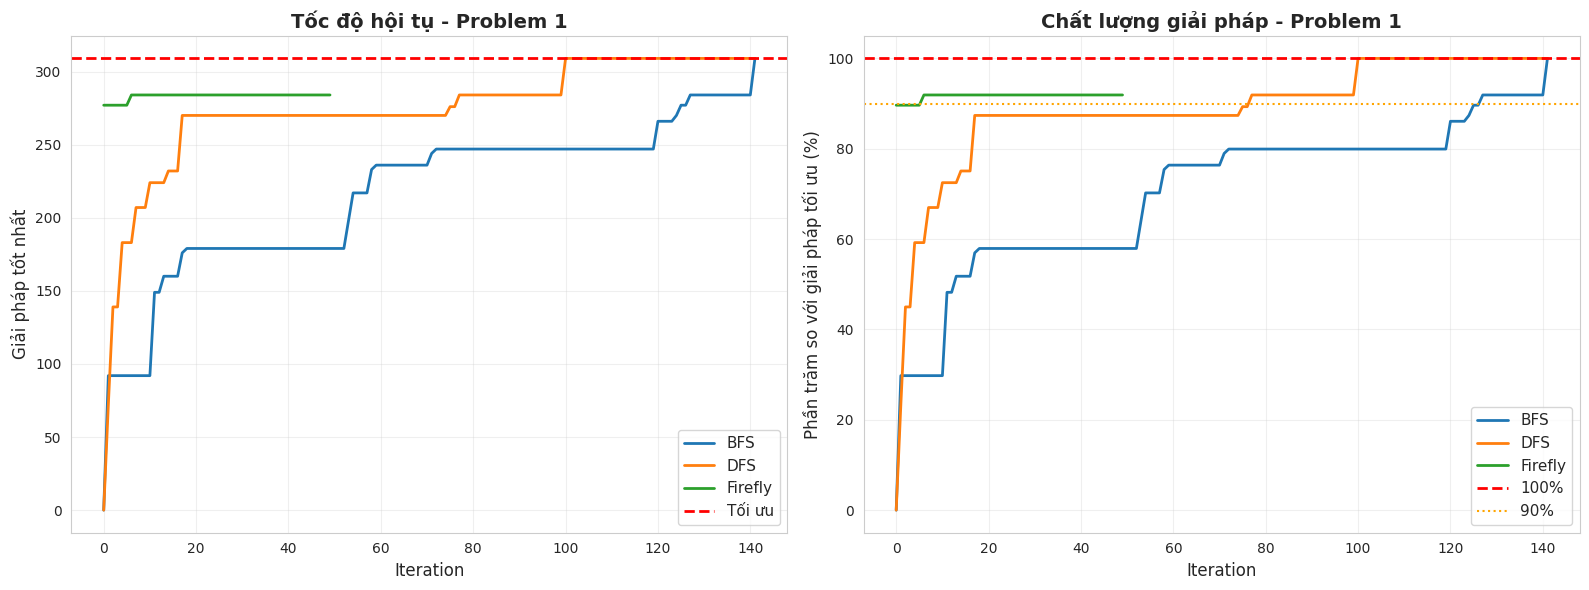

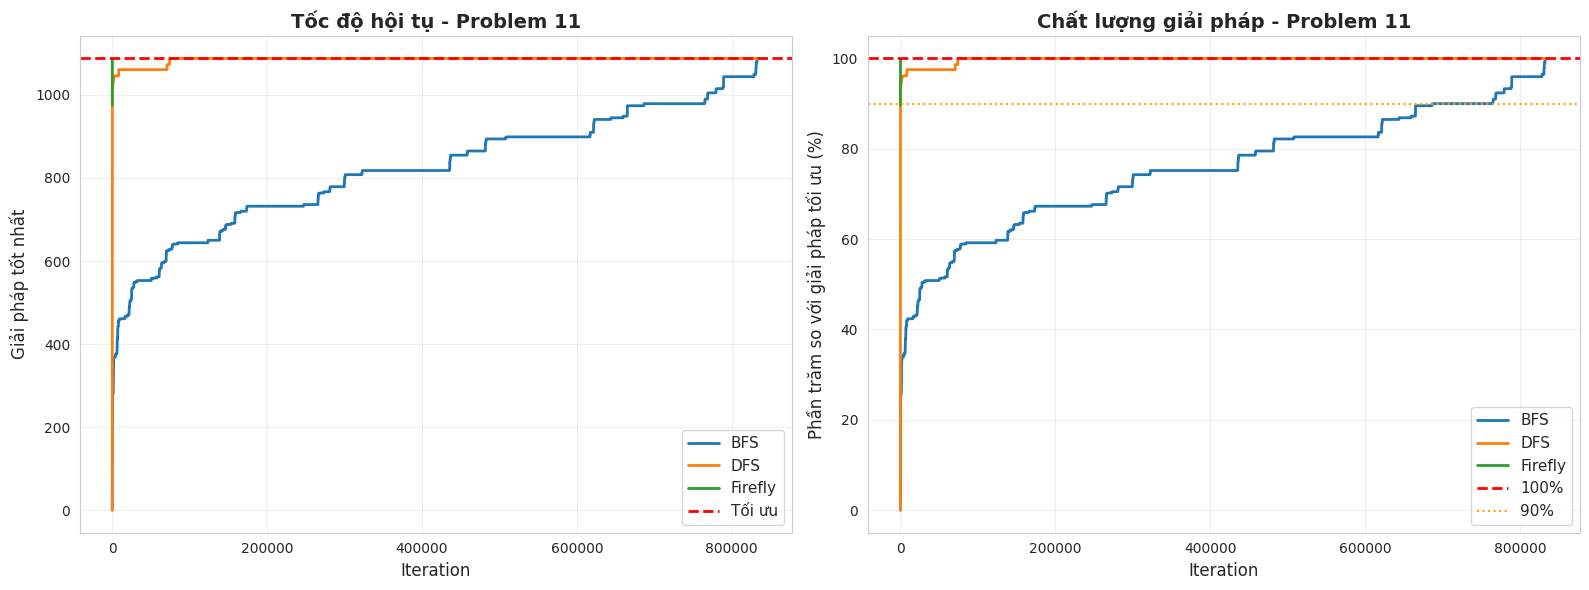

/tmp/ipykernel_8493/647154395.py:50: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


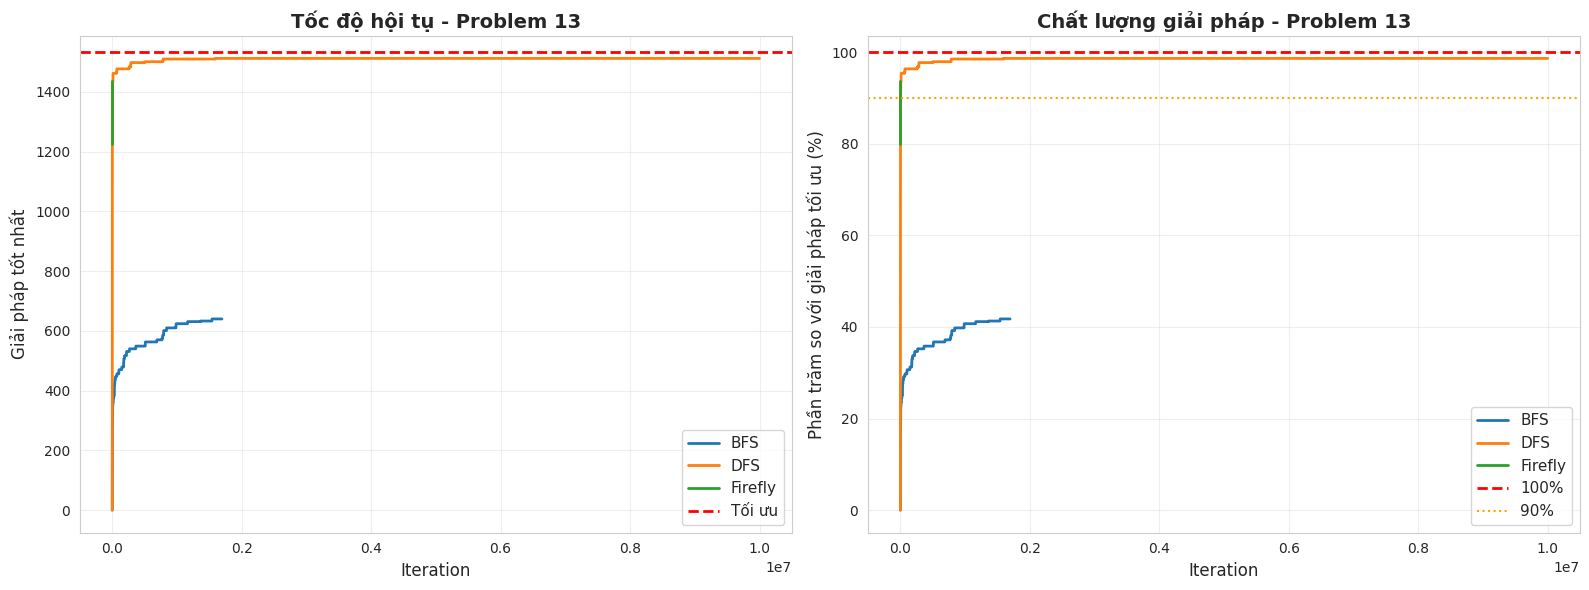

In [10]:
# Plot convergence curves for a specific problem
def plot_convergence(results_df, problem_num):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    problem_data = results_df[results_df["Problem"] == problem_num]

    # Plot 1: Convergence over iterations
    ax1 = axes[0]
    for _, row in problem_data.iterrows():
        history = row["Convergence History"]
        ax1.plot(history, label=row["Algorithm"], linewidth=2)

    ax1.axhline(
        y=problem_data.iloc[0]["Optimal Profit"],
        color="red",
        linestyle="--",
        label="Tối ưu",
        linewidth=2,
    )
    ax1.set_xlabel("Iteration", fontsize=12)
    ax1.set_ylabel("Giải pháp tốt nhất", fontsize=12)
    ax1.set_title(
        f"Tốc độ hội tụ - Problem {problem_num}", fontsize=14, fontweight="bold"
    )
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Time to reach percentage of optimal
    ax2 = axes[1]
    optimal_profit = problem_data.iloc[0]["Optimal Profit"]

    for _, row in problem_data.iterrows():
        history = row["Convergence History"]
        percentages = [h / optimal_profit * 100 for h in history]
        iterations = list(range(len(percentages)))
        ax2.plot(iterations, percentages, label=row["Algorithm"], linewidth=2)

    ax2.axhline(y=100, color="red", linestyle="--", label="100%", linewidth=2)
    ax2.axhline(y=90, color="orange", linestyle=":", label="90%", linewidth=1.5)
    ax2.set_xlabel("Iteration", fontsize=12)
    ax2.set_ylabel("Phần trăm so với giải pháp tối ưu (%)", fontsize=12)
    ax2.set_title(
        f"Chất lượng giải pháp - Problem {problem_num}",
        fontsize=14,
        fontweight="bold",
    )
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Plot for different problem sizes
for prob in [1, 11, 13]:
    if prob in all_results["Problem"].values:
        plot_convergence(all_results, prob)

### 5.2 Metric 2: Computational Complexity

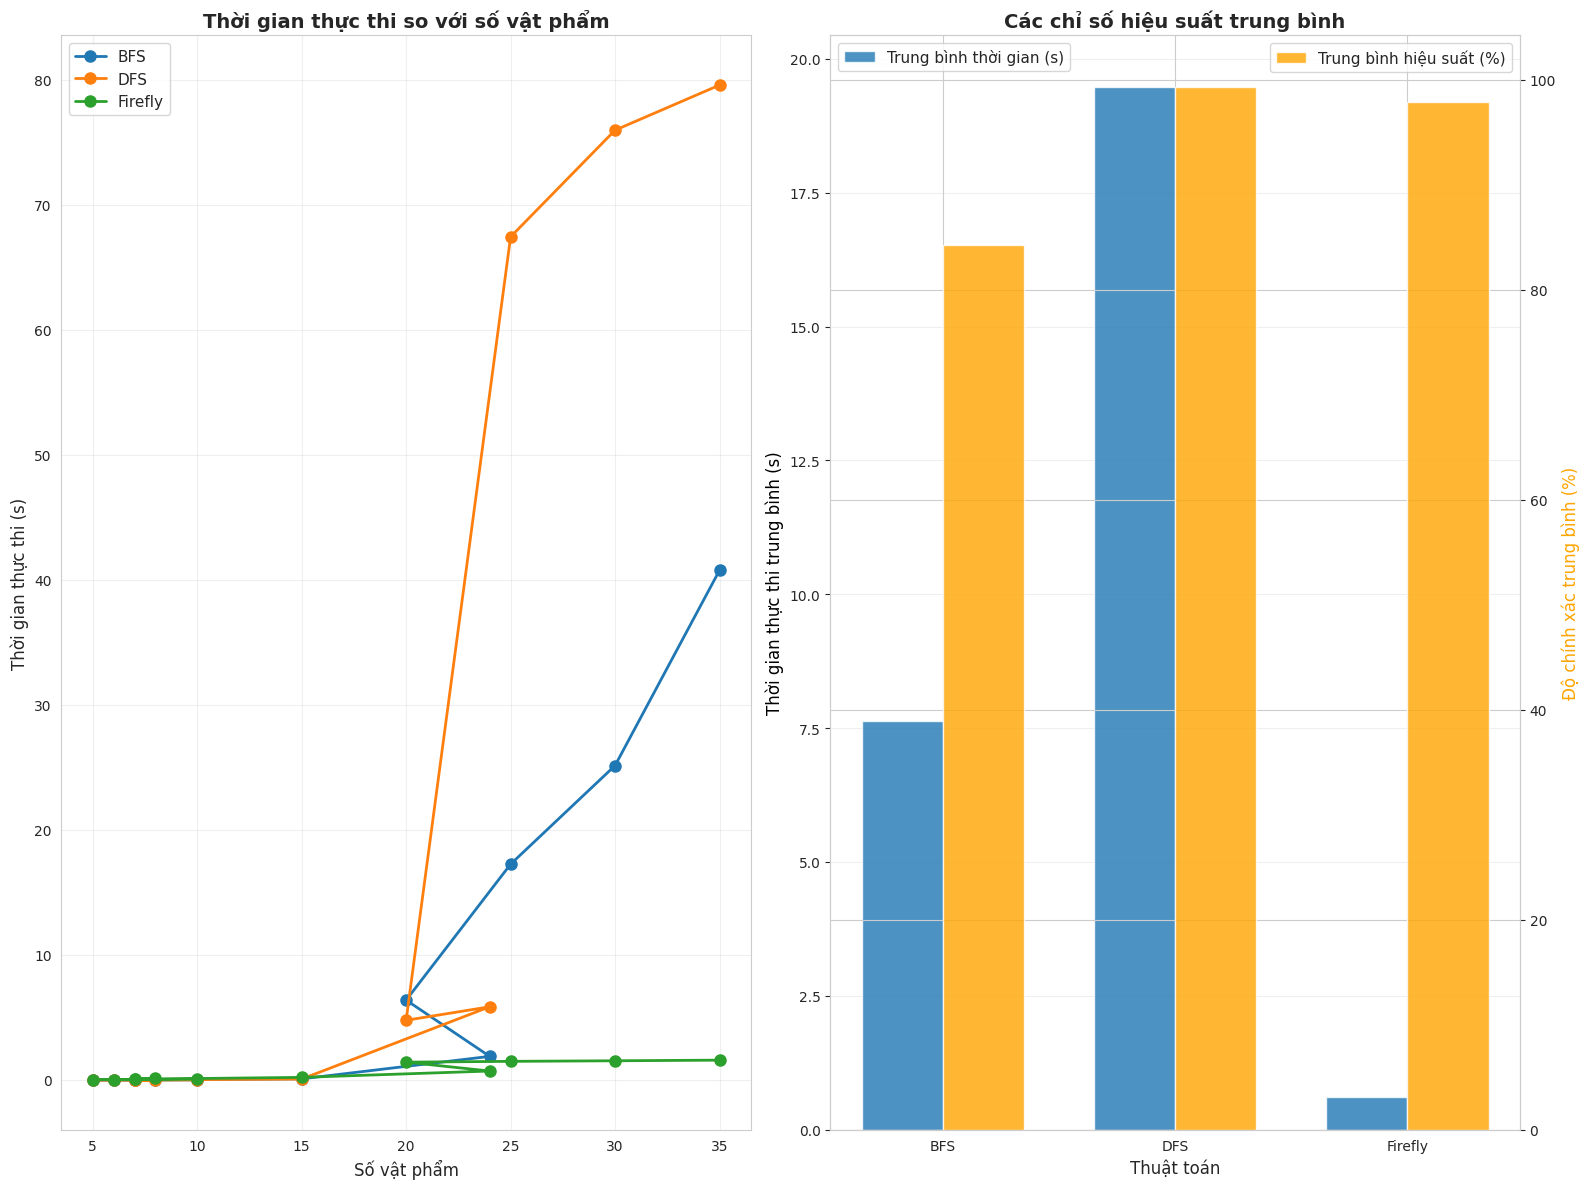


Average Performance Metrics:
Algorithm  Time (s)  Accuracy (%)
      BFS  7.624482     84.282411
      DFS 19.468135     99.259134
  Firefly  0.606716     97.847929


In [21]:
# Compare computational metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 12))

# Plot 1: Execution Time vs Problem Size
ax1 = axes[0]
for algo in all_results["Algorithm"].unique():
    algo_data = all_results[all_results["Algorithm"] == algo]
    ax1.plot(
        algo_data["Num Items"],
        algo_data["Time (s)"],
        marker="o",
        label=algo,
        linewidth=2,
        markersize=8,
    )

ax1.set_xlabel("Số vật phẩm", fontsize=12)
ax1.set_ylabel("Thời gian thực thi (s)", fontsize=12)
ax1.set_title("Thời gian thực thi so với số vật phẩm", fontsize=14, fontweight="bold")
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)


# Plot 2: Bar chart comparison for average metrics
ax4 = axes[1]
avg_metrics = (
    all_results.groupby("Algorithm")
    .agg({"Time (s)": "mean", "Accuracy (%)": "mean"})
    .reset_index()
)

x = np.arange(len(avg_metrics))
width = 0.35

bars1 = ax4.bar(
    x - width / 2,
    avg_metrics["Time (s)"],
    width,
    label="Trung bình thời gian (s)",
    alpha=0.8,
)
ax4_twin = ax4.twinx()
bars2 = ax4_twin.bar(
    x + width / 2,
    avg_metrics["Accuracy (%)"],
    width,
    label="Trung bình hiệu suất (%)",
    alpha=0.8,
    color="orange",
)

ax4.set_xlabel("Thuật toán", fontsize=12)
ax4.set_ylabel("Thời gian thực thi trung bình (s)", fontsize=12, color="black")
ax4_twin.set_ylabel("Độ chính xác trung bình (%)", fontsize=12, color="orange")
ax4.set_title("Các chỉ số hiệu suất trung bình", fontsize=14, fontweight="bold")
ax4.set_xticks(x)
ax4.set_xticklabels(avg_metrics["Algorithm"])
ax4.legend(loc="upper left", fontsize=11)
ax4_twin.legend(loc="upper right", fontsize=11)
ax4.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

print("\nAverage Performance Metrics:")
print(avg_metrics.to_string(index=False))

### 5.3 Metric 3: Robustness (Consistency across different problems)

/tmp/ipykernel_8493/757122639.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(accuracy_data, labels=labels, patch_artist=True)


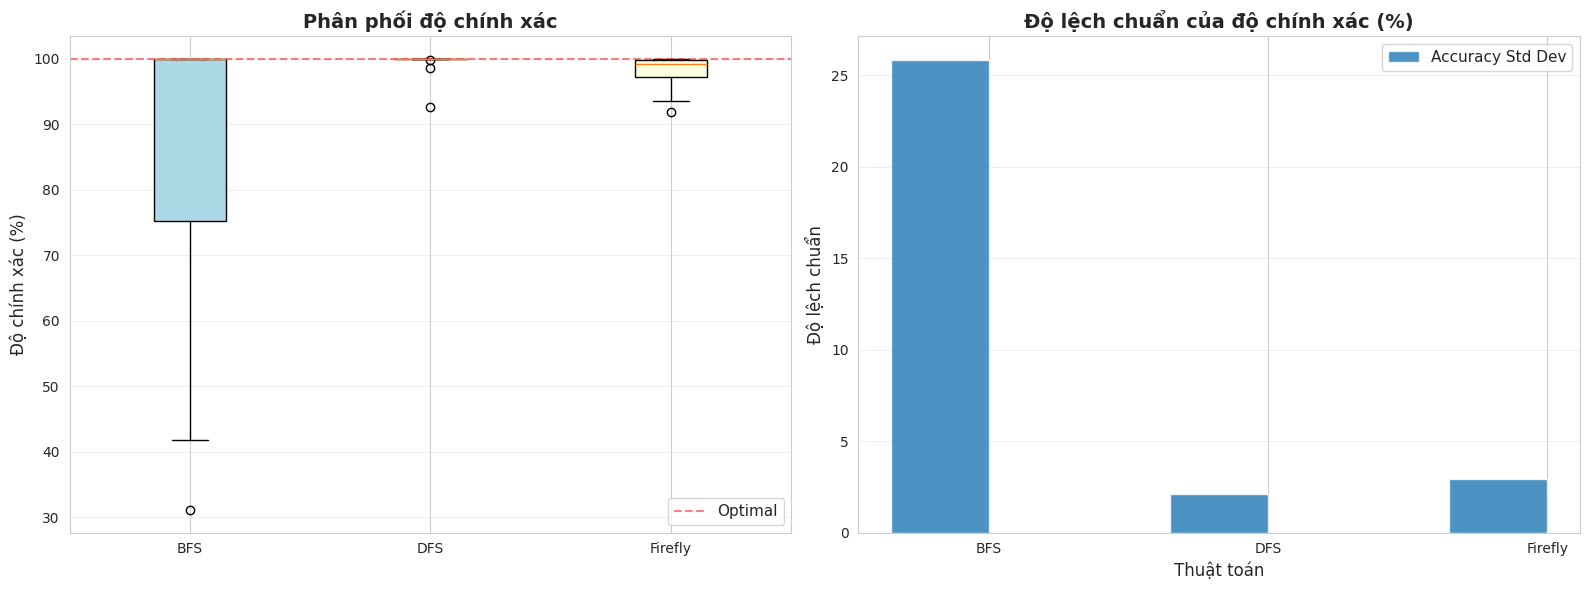


Robustness Metrics:
Algorithm  Accuracy Mean  Accuracy Std  Time Mean  Time Std
      BFS      84.282411     25.847703   7.624482 13.270618
      DFS      99.259134      2.122022  19.468135 33.238525
  Firefly      97.847929      2.915591   0.606716  0.688361

Coefficient of Variation (lower is better):
BFS: CV(Accuracy) = 0.3067, CV(Time) = 1.7405
DFS: CV(Accuracy) = 0.0214, CV(Time) = 1.7073
Firefly: CV(Accuracy) = 0.0298, CV(Time) = 1.1346


In [22]:
# Analyze robustness
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy distribution
ax1 = axes[0]
accuracy_data = []
labels = []
for algo in all_results["Algorithm"].unique():
    algo_data = all_results[all_results["Algorithm"] == algo]["Accuracy (%)"]
    accuracy_data.append(algo_data)
    labels.append(algo)

bp = ax1.boxplot(accuracy_data, labels=labels, patch_artist=True)
for patch, color in zip(bp["boxes"], ["lightblue", "lightgreen", "lightyellow"]):
    patch.set_facecolor(color)

ax1.set_ylabel("Độ chính xác (%)", fontsize=12)
ax1.set_title("Phân phối độ chính xác", fontsize=14, fontweight="bold")
ax1.grid(True, alpha=0.3, axis="y")
ax1.axhline(y=100, color="red", linestyle="--", alpha=0.5, label="Optimal")
ax1.legend(fontsize=11)

# Plot 2: Standard deviation of metrics
ax2 = axes[1]
robustness_metrics = (
    all_results.groupby("Algorithm")
    .agg({"Accuracy (%)": ["mean", "std"], "Time (s)": ["mean", "std"]})
    .reset_index()
)

robustness_metrics.columns = [
    "Algorithm",
    "Accuracy Mean",
    "Accuracy Std",
    "Time Mean",
    "Time Std",
]

x = np.arange(len(robustness_metrics))
width = 0.35

bars1 = ax2.bar(
    x - width / 2,
    robustness_metrics["Accuracy Std"],
    width,
    label="Accuracy Std Dev",
    alpha=0.8,
)
ax2.set_xlabel("Thuật toán", fontsize=12)
ax2.set_ylabel("Độ lệch chuẩn", fontsize=12)
ax2.set_title("Độ lệch chuẩn của độ chính xác (%)", fontsize=14, fontweight="bold")
ax2.set_xticks(x)
ax2.set_xticklabels(robustness_metrics["Algorithm"])
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

print("\nRobustness Metrics:")
print(robustness_metrics.to_string(index=False))

print("\nCoefficient of Variation (lower is better):")
for algo in all_results["Algorithm"].unique():
    algo_data = all_results[all_results["Algorithm"] == algo]
    cv_accuracy = algo_data["Accuracy (%)"].std() / algo_data["Accuracy (%)"].mean()
    cv_time = algo_data["Time (s)"].std() / algo_data["Time (s)"].mean()
    print(f"{algo}: CV(Accuracy) = {cv_accuracy:.4f}, CV(Time) = {cv_time:.4f}")

### 5.4 Metric 4: Scalability

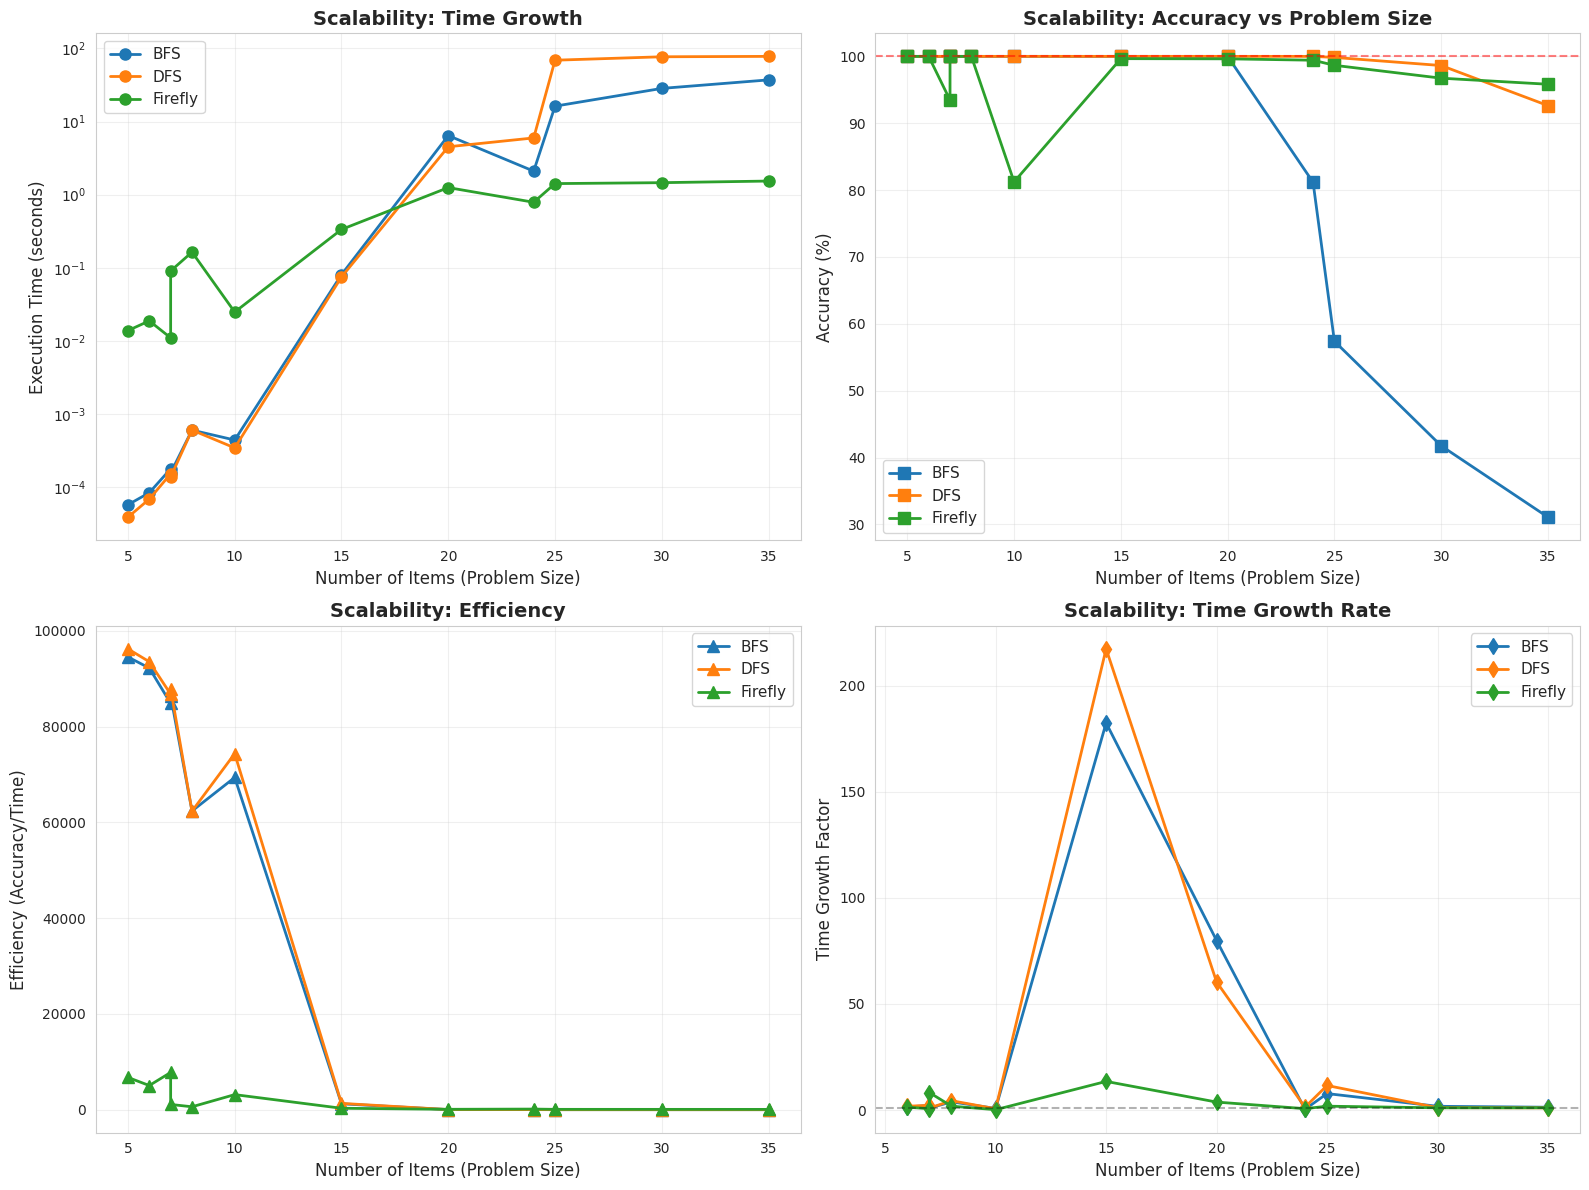

In [26]:
# Analyze scalability
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Time complexity growth rate
ax1 = axes[0, 0]
for algo in all_results["Algorithm"].unique():
    algo_data = all_results[all_results["Algorithm"] == algo].sort_values("Num Items")
    ax1.plot(
        algo_data["Num Items"],
        algo_data["Time (s)"],
        marker="o",
        label=algo,
        linewidth=2,
        markersize=8,
    )

ax1.set_xlabel("Number of Items (Problem Size)", fontsize=12)
ax1.set_ylabel("Execution Time (seconds)", fontsize=12)
ax1.set_title("Scalability: Time Growth", fontsize=14, fontweight="bold")
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_yscale("log")

# Plot 2: Accuracy degradation with size
ax2 = axes[0, 1]
for algo in all_results["Algorithm"].unique():
    algo_data = all_results[all_results["Algorithm"] == algo].sort_values("Num Items")
    ax2.plot(
        algo_data["Num Items"],
        algo_data["Accuracy (%)"],
        marker="s",
        label=algo,
        linewidth=2,
        markersize=8,
    )

ax2.set_xlabel("Number of Items (Problem Size)", fontsize=12)
ax2.set_ylabel("Accuracy (%)", fontsize=12)
ax2.set_title("Scalability: Accuracy vs Problem Size", fontsize=14, fontweight="bold")
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=100, color="red", linestyle="--", alpha=0.5)

# Plot 3: Efficiency (Accuracy / Time)
ax3 = axes[1, 0]
all_results["Efficiency"] = all_results["Accuracy (%)"] / (
    all_results["Time (s)"] + 0.001
)
for algo in all_results["Algorithm"].unique():
    algo_data = all_results[all_results["Algorithm"] == algo].sort_values("Num Items")
    ax3.plot(
        algo_data["Num Items"],
        algo_data["Efficiency"],
        marker="^",
        label=algo,
        linewidth=2,
        markersize=8,
    )

ax3.set_xlabel("Number of Items (Problem Size)", fontsize=12)
ax3.set_ylabel("Efficiency (Accuracy/Time)", fontsize=12)
ax3.set_title("Scalability: Efficiency", fontsize=14, fontweight="bold")
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# Plot 4: Scalability factor
ax4 = axes[1, 1]
for algo in all_results["Algorithm"].unique():
    algo_data = all_results[all_results["Algorithm"] == algo].sort_values("Num Items")
    if len(algo_data) > 1:
        time_ratios = []
        sizes = []
        for i in range(1, len(algo_data)):
            ratio = algo_data.iloc[i]["Time (s)"] / algo_data.iloc[i - 1]["Time (s)"]
            time_ratios.append(ratio)
            sizes.append(algo_data.iloc[i]["Num Items"])
        ax4.plot(sizes, time_ratios, marker="d", label=algo, linewidth=2, markersize=8)

ax4.set_xlabel("Number of Items (Problem Size)", fontsize=12)
ax4.set_ylabel("Time Growth Factor", fontsize=12)
ax4.set_title("Scalability: Time Growth Rate", fontsize=14, fontweight="bold")
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)
ax4.axhline(y=1, color="black", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Summary Statistics and Comparison Table

In [27]:
# Create comprehensive comparison table
summary_stats = (
    all_results.groupby("Algorithm")
    .agg(
        {
            "Accuracy (%)": ["mean", "std", "min", "max"],
            "Time (s)": ["mean", "std", "min", "max"],
            "Iterations": ["mean", "std"],
            "States Explored": ["mean", "std"],
        }
    )
    .round(4)
)

print("\n" + "=" * 100)
print("COMPREHENSIVE COMPARISON SUMMARY")
print("=" * 100)
print(summary_stats)

# Calculate ranking for each metric (lower is better for time, higher for accuracy)
print("\n" + "=" * 100)
print("ALGORITHM RANKINGS")
print("=" * 100)

avg_metrics = (
    all_results.groupby("Algorithm")
    .agg({"Accuracy (%)": "mean", "Time (s)": "mean", "States Explored": "mean"})
    .reset_index()
)

# Rank (1 is best)
avg_metrics["Accuracy Rank"] = avg_metrics["Accuracy (%)"].rank(ascending=False)
avg_metrics["Time Rank"] = avg_metrics["Time (s)"].rank(ascending=True)
avg_metrics["Complexity Rank"] = avg_metrics["States Explored"].rank(ascending=True)

# Calculate robustness (inverse of std dev)
robustness = all_results.groupby("Algorithm")["Accuracy (%)"].std().reset_index()
robustness.columns = ["Algorithm", "Accuracy Std"]
robustness["Robustness Rank"] = robustness["Accuracy Std"].rank(ascending=True)

# Merge rankings
ranking_df = avg_metrics.merge(
    robustness[["Algorithm", "Robustness Rank"]], on="Algorithm"
)
ranking_df["Overall Score"] = (
    ranking_df["Accuracy Rank"]
    + ranking_df["Time Rank"]
    + ranking_df["Complexity Rank"]
    + ranking_df["Robustness Rank"]
) / 4
ranking_df = ranking_df.sort_values("Overall Score")

print(
    ranking_df[
        [
            "Algorithm",
            "Accuracy Rank",
            "Time Rank",
            "Complexity Rank",
            "Robustness Rank",
            "Overall Score",
        ]
    ].to_string(index=False)
)


COMPREHENSIVE COMPARISON SUMMARY
          Accuracy (%)                          Time (s)                   \
                  mean      std      min    max     mean      std     min   
Algorithm                                                                   
BFS            84.2824  25.8477  31.0774  100.0   7.5321  12.8425  0.0001   
DFS            99.2591   2.1220  92.6367  100.0  19.5275  33.3265  0.0000   
Firefly        97.0529   5.4044  81.2298  100.0   0.5923   0.6480  0.0110   

                      Iterations               States Explored                
               max          mean           std            mean           std  
Algorithm                                                                     
BFS        37.1326  3.237641e+06  4.622715e+06    5.016982e+05  7.419843e+05  
DFS        77.8675  2.654576e+06  4.442948e+06    2.654576e+06  4.442948e+06  
Firefly     1.5357  1.000000e+02  4.264010e+01    4.666667e+03  2.570226e+03  

ALGORITHM RANKINGS
Algorithm

## 7. Final Visualization: Radar Chart Comparison

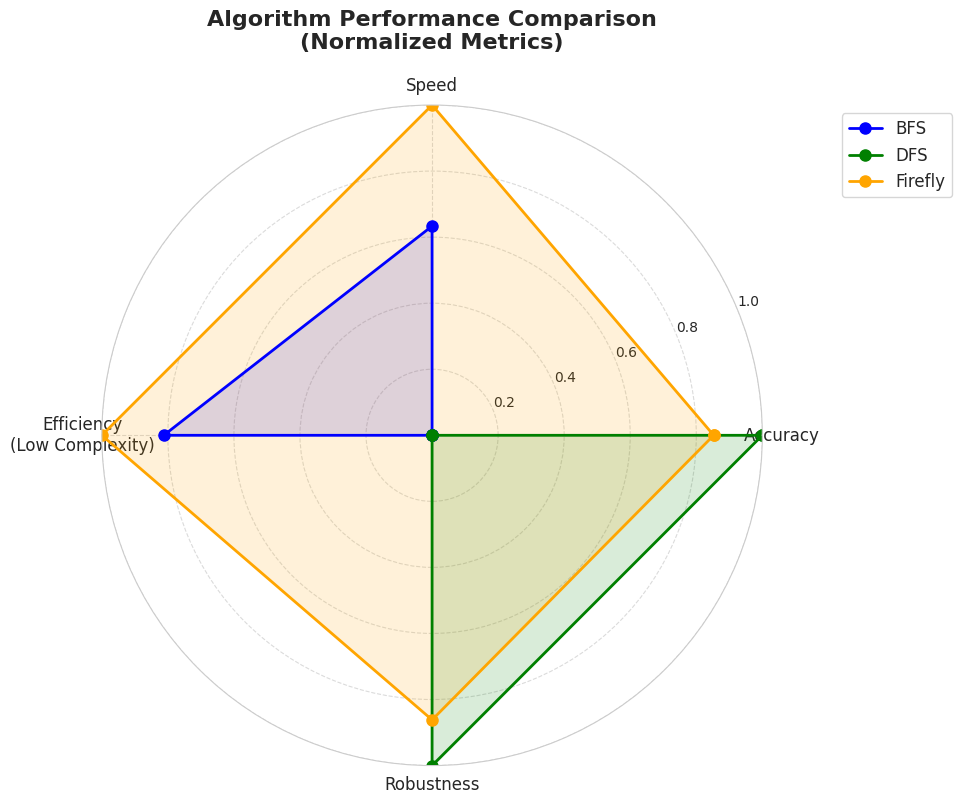

In [28]:
import matplotlib.pyplot as plt
import numpy as np


# Normalize metrics to 0-1 scale for radar chart
def normalize_metric(values, higher_is_better=True):
    min_val, max_val = values.min(), values.max()
    if max_val == min_val:
        return np.ones_like(values)
    normalized = (values - min_val) / (max_val - min_val)
    return normalized if higher_is_better else 1 - normalized


# Prepare data
radar_data = (
    all_results.groupby("Algorithm")
    .agg(
        {
            "Accuracy (%)": "mean",
            "Time (s)": "mean",
            "States Explored": "mean",
        }
    )
    .reset_index()
)

# Add robustness (inverse of std dev)
robustness_metric = all_results.groupby("Algorithm")["Accuracy (%)"].std()
radar_data["Robustness"] = radar_data["Algorithm"].map(robustness_metric)

# Normalize
radar_data["Accuracy_norm"] = normalize_metric(radar_data["Accuracy (%)"].values, True)
radar_data["Speed_norm"] = normalize_metric(
    radar_data["Time (s)"].values, False
)  # Lower is better
radar_data["Efficiency_norm"] = normalize_metric(
    radar_data["States Explored"].values, False
)
radar_data["Robustness_norm"] = normalize_metric(
    radar_data["Robustness"].values, False
)  # Lower std is better

# Create radar chart
categories = ["Accuracy", "Speed", "Efficiency\n(Low Complexity)", "Robustness"]
N = len(categories)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="polar"))

colors = ["blue", "green", "orange"]
for idx, row in radar_data.iterrows():
    values = [
        row["Accuracy_norm"],
        row["Speed_norm"],
        row["Efficiency_norm"],
        row["Robustness_norm"],
    ]
    values += values[:1]

    ax.plot(
        angles,
        values,
        "o-",
        linewidth=2,
        label=row["Algorithm"],
        color=colors[idx],
        markersize=8,
    )
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], size=10)
ax.grid(True, linestyle="--", alpha=0.7)
ax.set_title(
    "Algorithm Performance Comparison\n(Normalized Metrics)",
    size=16,
    fontweight="bold",
    pad=20,
)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.0), fontsize=12)

plt.tight_layout()
plt.show()